In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from subprocess import Popen, PIPE, STDOUT
import matplotlib.pyplot as plt
import os
from copy import deepcopy
import galsim 

In [3]:
#directories that would be using 
repo = '/Users/Ismael/code/lensing/SMFF/'
os.chdir(repo)

In [4]:
#colormap default to use for galaxy 
cmap = 'RdYlGn'

In [5]:
def showImage(image,ax=None):
    if ax is None: 
        plt.imshow(image, cmap=cmap,vmax=abs(image).max(),vmin=-abs(image).max(),interpolation='None')
    else: 
        ax.imshow(image, cmap=cmap,vmax=abs(image).max(),vmin=-abs(image).max(),interpolation='None')

## Analysis on two galaxies 

### Generate two galaxies 

In [34]:
#parameters of first galaxy to draw. we assume that both galaxies have same psf and snr (which only depends on the background) throughout. 

model_1 = 'gaussian' #possible options of model and psf_model are in documentation. 
e1_1 = 0. 
e2_1 = 0. 
hlr_1 = .5
flux_1 = 1. 
x0_1 = .2 #this is in arcsecs
y0_1 = 0. 

#parameters of second galaxy to draw. 
model_2 = 'gaussian'  
e1_2 = 0.
e2_2 = 0. 
hlr_2 = 1.
flux_2 = 1. 
x0_2 = -.2
y0_2 = 0.

#general parameters
snr = 20. 
psf_fwhm = .7
psf_model = 'psf_gaussian'


#project folder name where you want to write galaxy information 
project2 = 'project-tutorial2'

#image parameters 
pixel_scale=.2 
nx = 60
ny = 60 

In [35]:
cmd1 = 'python generate.py -p {0} -gal 1 --galaxy-model {1} --psf_model {2}  --e1 {3} --e2 {4} --x0 {5} --y0 {6} \
--flux {7} --psf_flux 1. --hlr {8} --psf_fwhm {9} --snr {10}'.format(project2,model_1,psf_model,e1_1,e2_1,x0_1,y0_1,flux_1,hlr_1,psf_fwhm,snr)
p1 = Popen(cmd1, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output1 = p1.stdout.read()
print output1

In [36]:
cmd2 = 'python generate.py -p {0} -gal 2 --galaxy-model {1} --psf_model {2}  --e1 {3} --e2 {4} --x0 {5} --y0 {6} \
--flux {7} --psf_flux 1. --hlr {8} --psf_fwhm {9} --snr {10}'.format(project2,model_2,psf_model,e1_2,e2_2,x0_2,y0_2,flux_2,hlr_2,psf_fwhm,snr)
p2 = Popen(cmd2, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output2 = p2.stdout.read()
print output2


### Drawing galaxies 

In [37]:
import analysis.fisher as fisher
import analysis.galfun as galfun

In [38]:
#works the same way as before, 
g_parameters = galfun.GParameters(project2) #extract parameters from file created by generate.py 
image_renderer = galfun.ImageRenderer(pixel_scale=pixel_scale,
                                      nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, 
                     snr=snr)

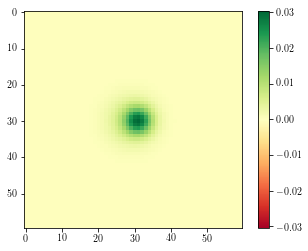

In [39]:
showImage(fish.image.array)
plt.colorbar()

### Showing the fisher matrix images for both galaxies.

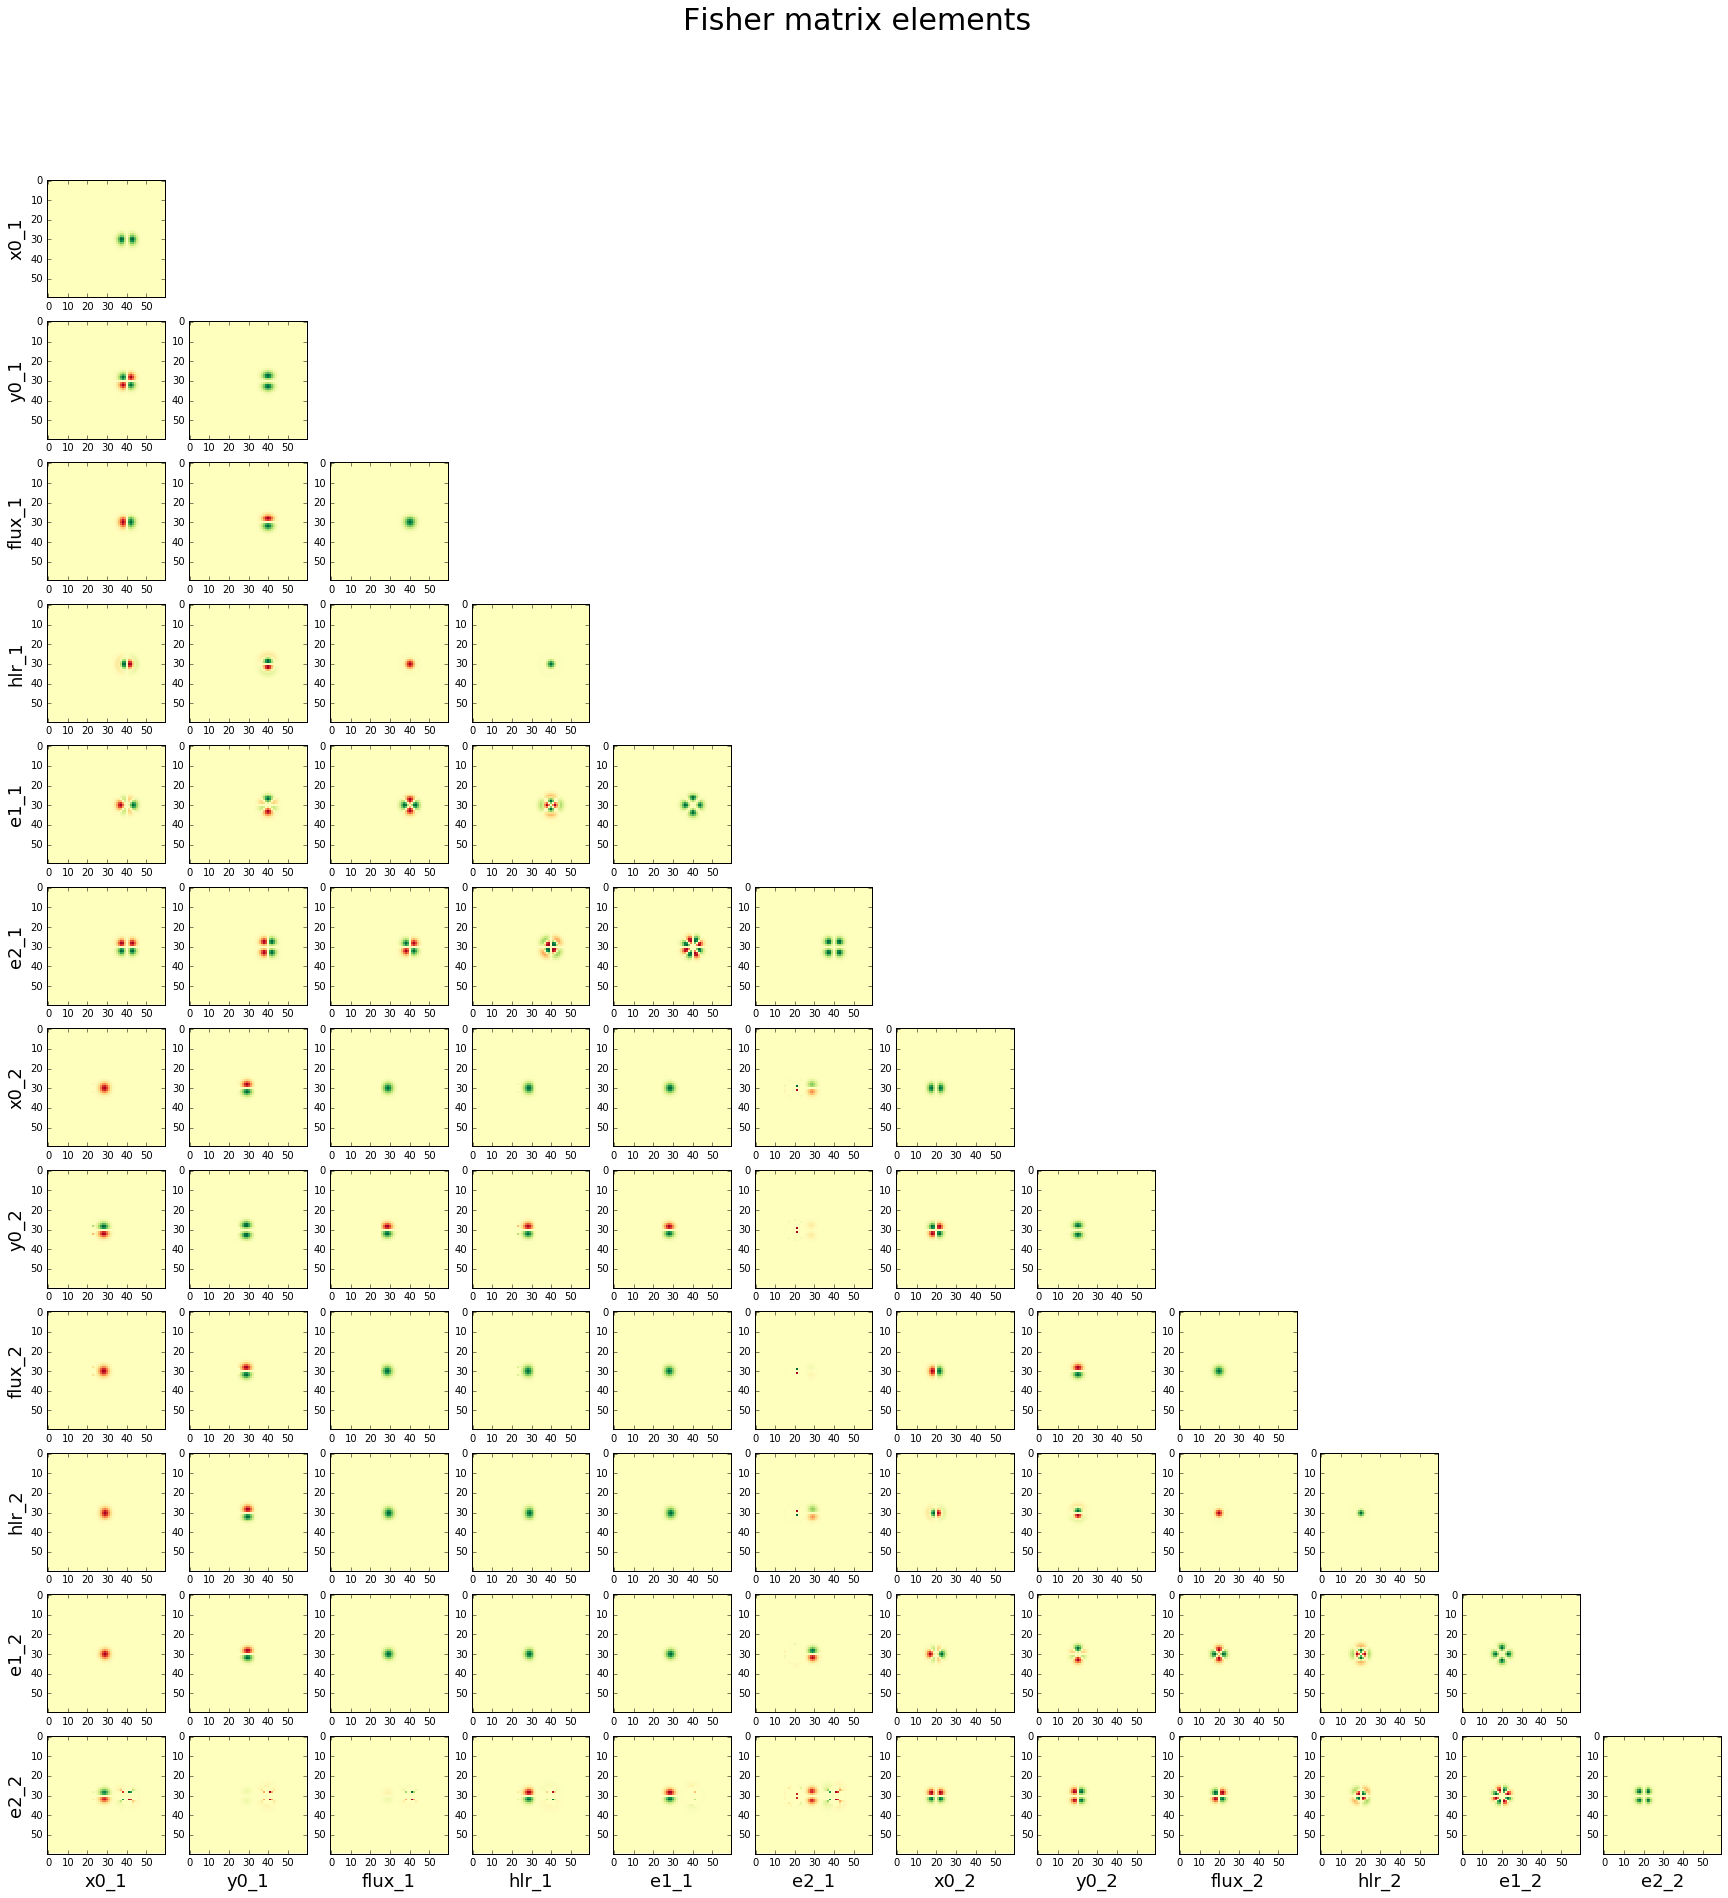

In [29]:
figure = plt.figure(figsize=(30,30))
figure.suptitle('Fisher matrix elements',
                fontsize=30)
for i in range(fish.num_params):
    for j in range(fish.num_params):
        if i >= j:
            ax = figure.add_subplot(fish.num_params,
                                    fish.num_params,
                                    fish.num_params * i + j + 1)
            showImage(fish.fisher_matrix_images[
                          fish.param_names[i],
                          fish.param_names[j]
                      ],ax)

            if j == 0:
                ax.set_ylabel(fish.param_names[i],fontsize=18)
            if i == fish.num_params - 1:
                ax.set_xlabel(fish.param_names[j],fontsize=18)

### Showing the bias images for both galaxies 

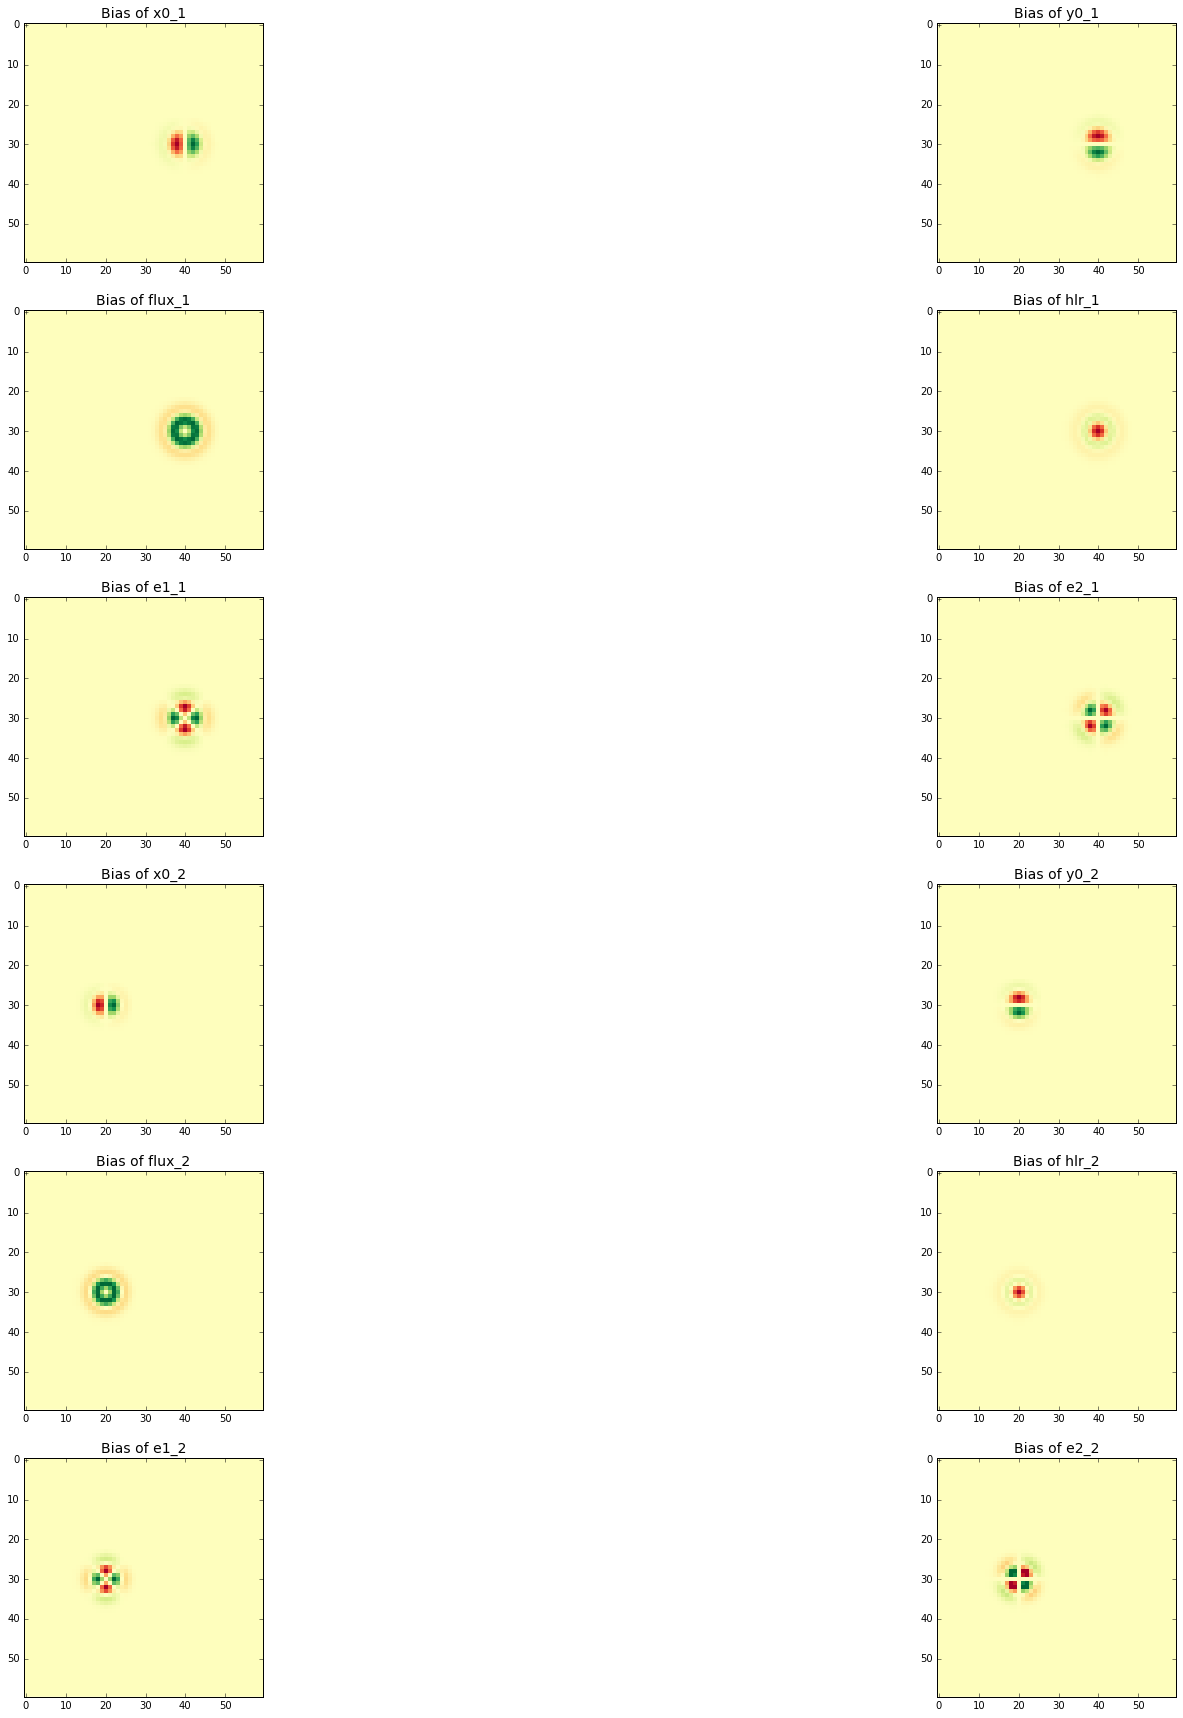

In [30]:
#draw bias images.
nrow,ncol = 6,2
fig = plt.figure(figsize=(30,30))
for i,name in enumerate(fish.param_names):
    image = fish.bias_images[name]
    plt.subplot(nrow,ncol,i+1)
    showImage(image)
    plt.title('Bias of {0}'.format(name),fontsize=14)
    #plt.colorbar()

### Bias as a function of their separation in each of the parameters. 

In [21]:
#assume both have y = 0
def biasSeparation(fish,image_renderer):
    separation_range = (.0, 3.0)  # arcsecs.
    steps = 50
    figure = plt.figure(figsize=(50, 50))
    figure.suptitle('Bias as a function of distance between two galaxies')
    id_params = deepcopy(fish.g_parameters.id_params)
    snr = fish.snr
    separations = np.linspace(separation_range[0], separation_range[1],
                              steps)
    biases = {}
    for separation in separations:
        pos1 = separation / 2
        pos2 = -separation / 2
        ids = id_params.keys()
        id1 = ids[0]
        id2 = ids[1]
        id_params[id1]['x0'] = pos1
        id_params[id2]['x0'] = pos2
        g_parameters = galfun.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters, image_renderer, snr)
        for i in range(fish.num_params):
            param = fish.param_names[i]
            if param not in biases:
                biases[param] = []
            bias = fish.biases[param]
            biases[param].append(bias)


    y_titles = [r'$b(x^{1}_{0})$', r'$b(y^{1}_{0})$', r'$b(flux^{1})$',
               r'$b(hlr^{1})$', r'$b(e^{1}_{1})$',
               r'$b(e^{1}_{2})$',
               r'$b(x^{2}_{0})$', r'$b(y^{2}_{0})$', r'$b(flux^{2})$',
               r'$b(hlr^{2})$', r'$b(e^{2}_{1})$',
               r'$b(e^{2}_{2})$']
    x_titles = [r'$\left|x^{2}_{0} - x^{1}_{0}\right|$'] * 12

    for i in range(fish.num_params):
        param = fish.param_names[i]
        ax = figure.add_subplot(2, fish.num_params / 2,
                                i + 1)
        ax.scatter(separations, biases[param])
        ax.errorbar(separations, biases[param])
        #ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel(x_titles[i], fontsize=30)
        ax.set_ylabel(y_titles[i], fontsize=30)
        ax.tick_params(labelsize=22)
        #scientic notation force.
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    

    figure.subplots_adjust(wspace=.3)

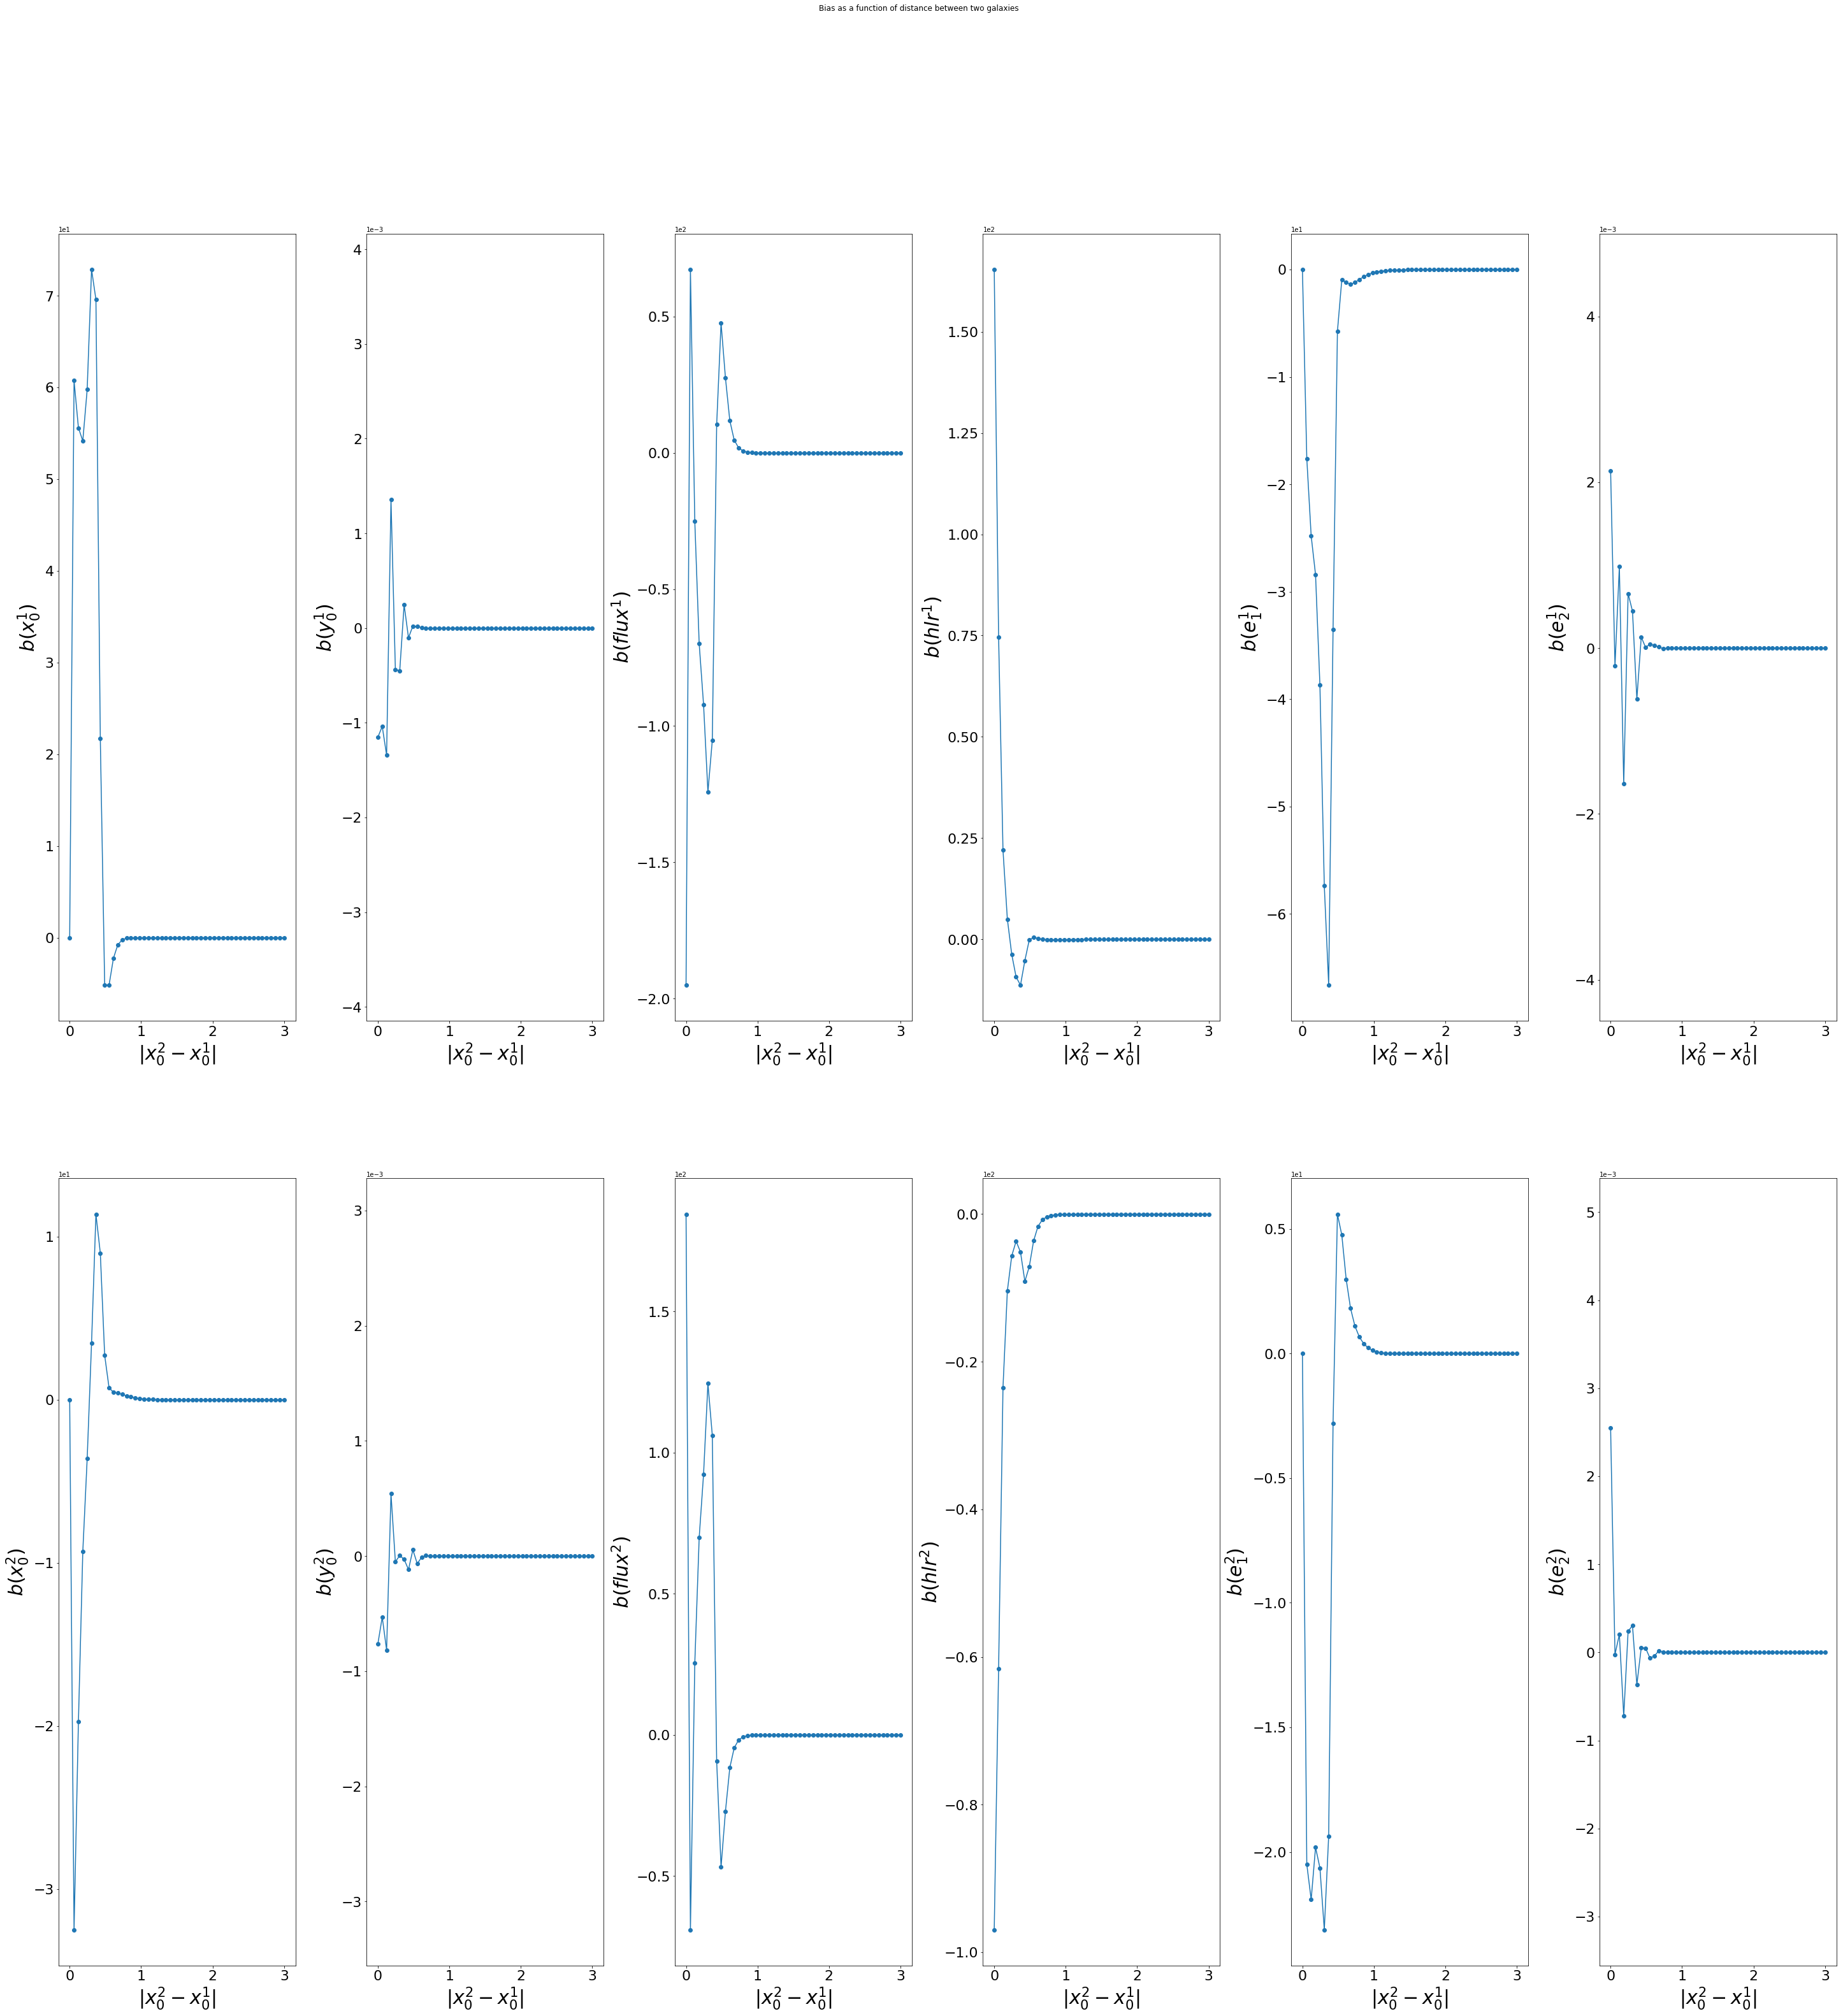

In [22]:
biasSeparation(fish,image_renderer)

In [40]:
#assume both have y = 0
def biasSeparation(fish,image_renderer,params,num_params):
    separation_range = (.0, 3.0)  # arcsecs.
    steps = 50
    figure = plt.figure(figsize=(50, 50))
    figure.suptitle('Bias as a function of distance between two galaxies')
    id_params = deepcopy(fish.g_parameters.id_params)
    snr = fish.snr
    separations = np.linspace(separation_range[0], separation_range[1],
                              steps)
    biases = {}
    for separation in separations:
        pos1 = separation / 2
        pos2 = -separation / 2
        ids = id_params.keys()
        id1 = ids[0]
        id2 = ids[1]
        id_params[id1]['x0'] = pos1
        id_params[id2]['x0'] = pos2
        g_parameters = galfun.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters, image_renderer, snr)
        for i in range(num_params):
            param = params[i]
            if param not in biases:
                biases[param] = []
            bias = fish.biases[param]
            biases[param].append(bias)


    y_titles = [r'$b(e^{1}_{1})$',
               r'$b(e^{1}_{2})$',
               r'$b(e^{2}_{1})$',
               r'$b(e^{2}_{2})$']
    x_titles = [r'$\left|x^{2}_{0} - x^{1}_{0}\right|$ [arcsecs]'] * 4
    units = ['$[10^{1}]$','$[10^{-3}]$', '[$10^{1}$]', '$[10^{-3}]$']
    
    y_final_titles = [y_title + ' {0}'.format(unit) for y_title,unit in zip(y_titles,units)]



    for i in range(num_params):
        plt.rc('text', usetex=True)
        param = params[i]
        ax = figure.add_subplot(2, num_params / 2,
                                i + 1)
        ax.scatter(separations, biases[param])
        ax.errorbar(separations, biases[param])
        #ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel(x_titles[i], fontsize=50)
        ax.set_ylabel(y_final_titles[i], fontsize=60)
        ax.tick_params(labelsize=40)
        ax.get_yaxis().get_offset_text().set_size(60)
        ax.tick_params(which='both', width=3,length = 12)
        plt.axhline(0,color='r')
        #scientic notation force.
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    figure.subplots_adjust(wspace=.3)

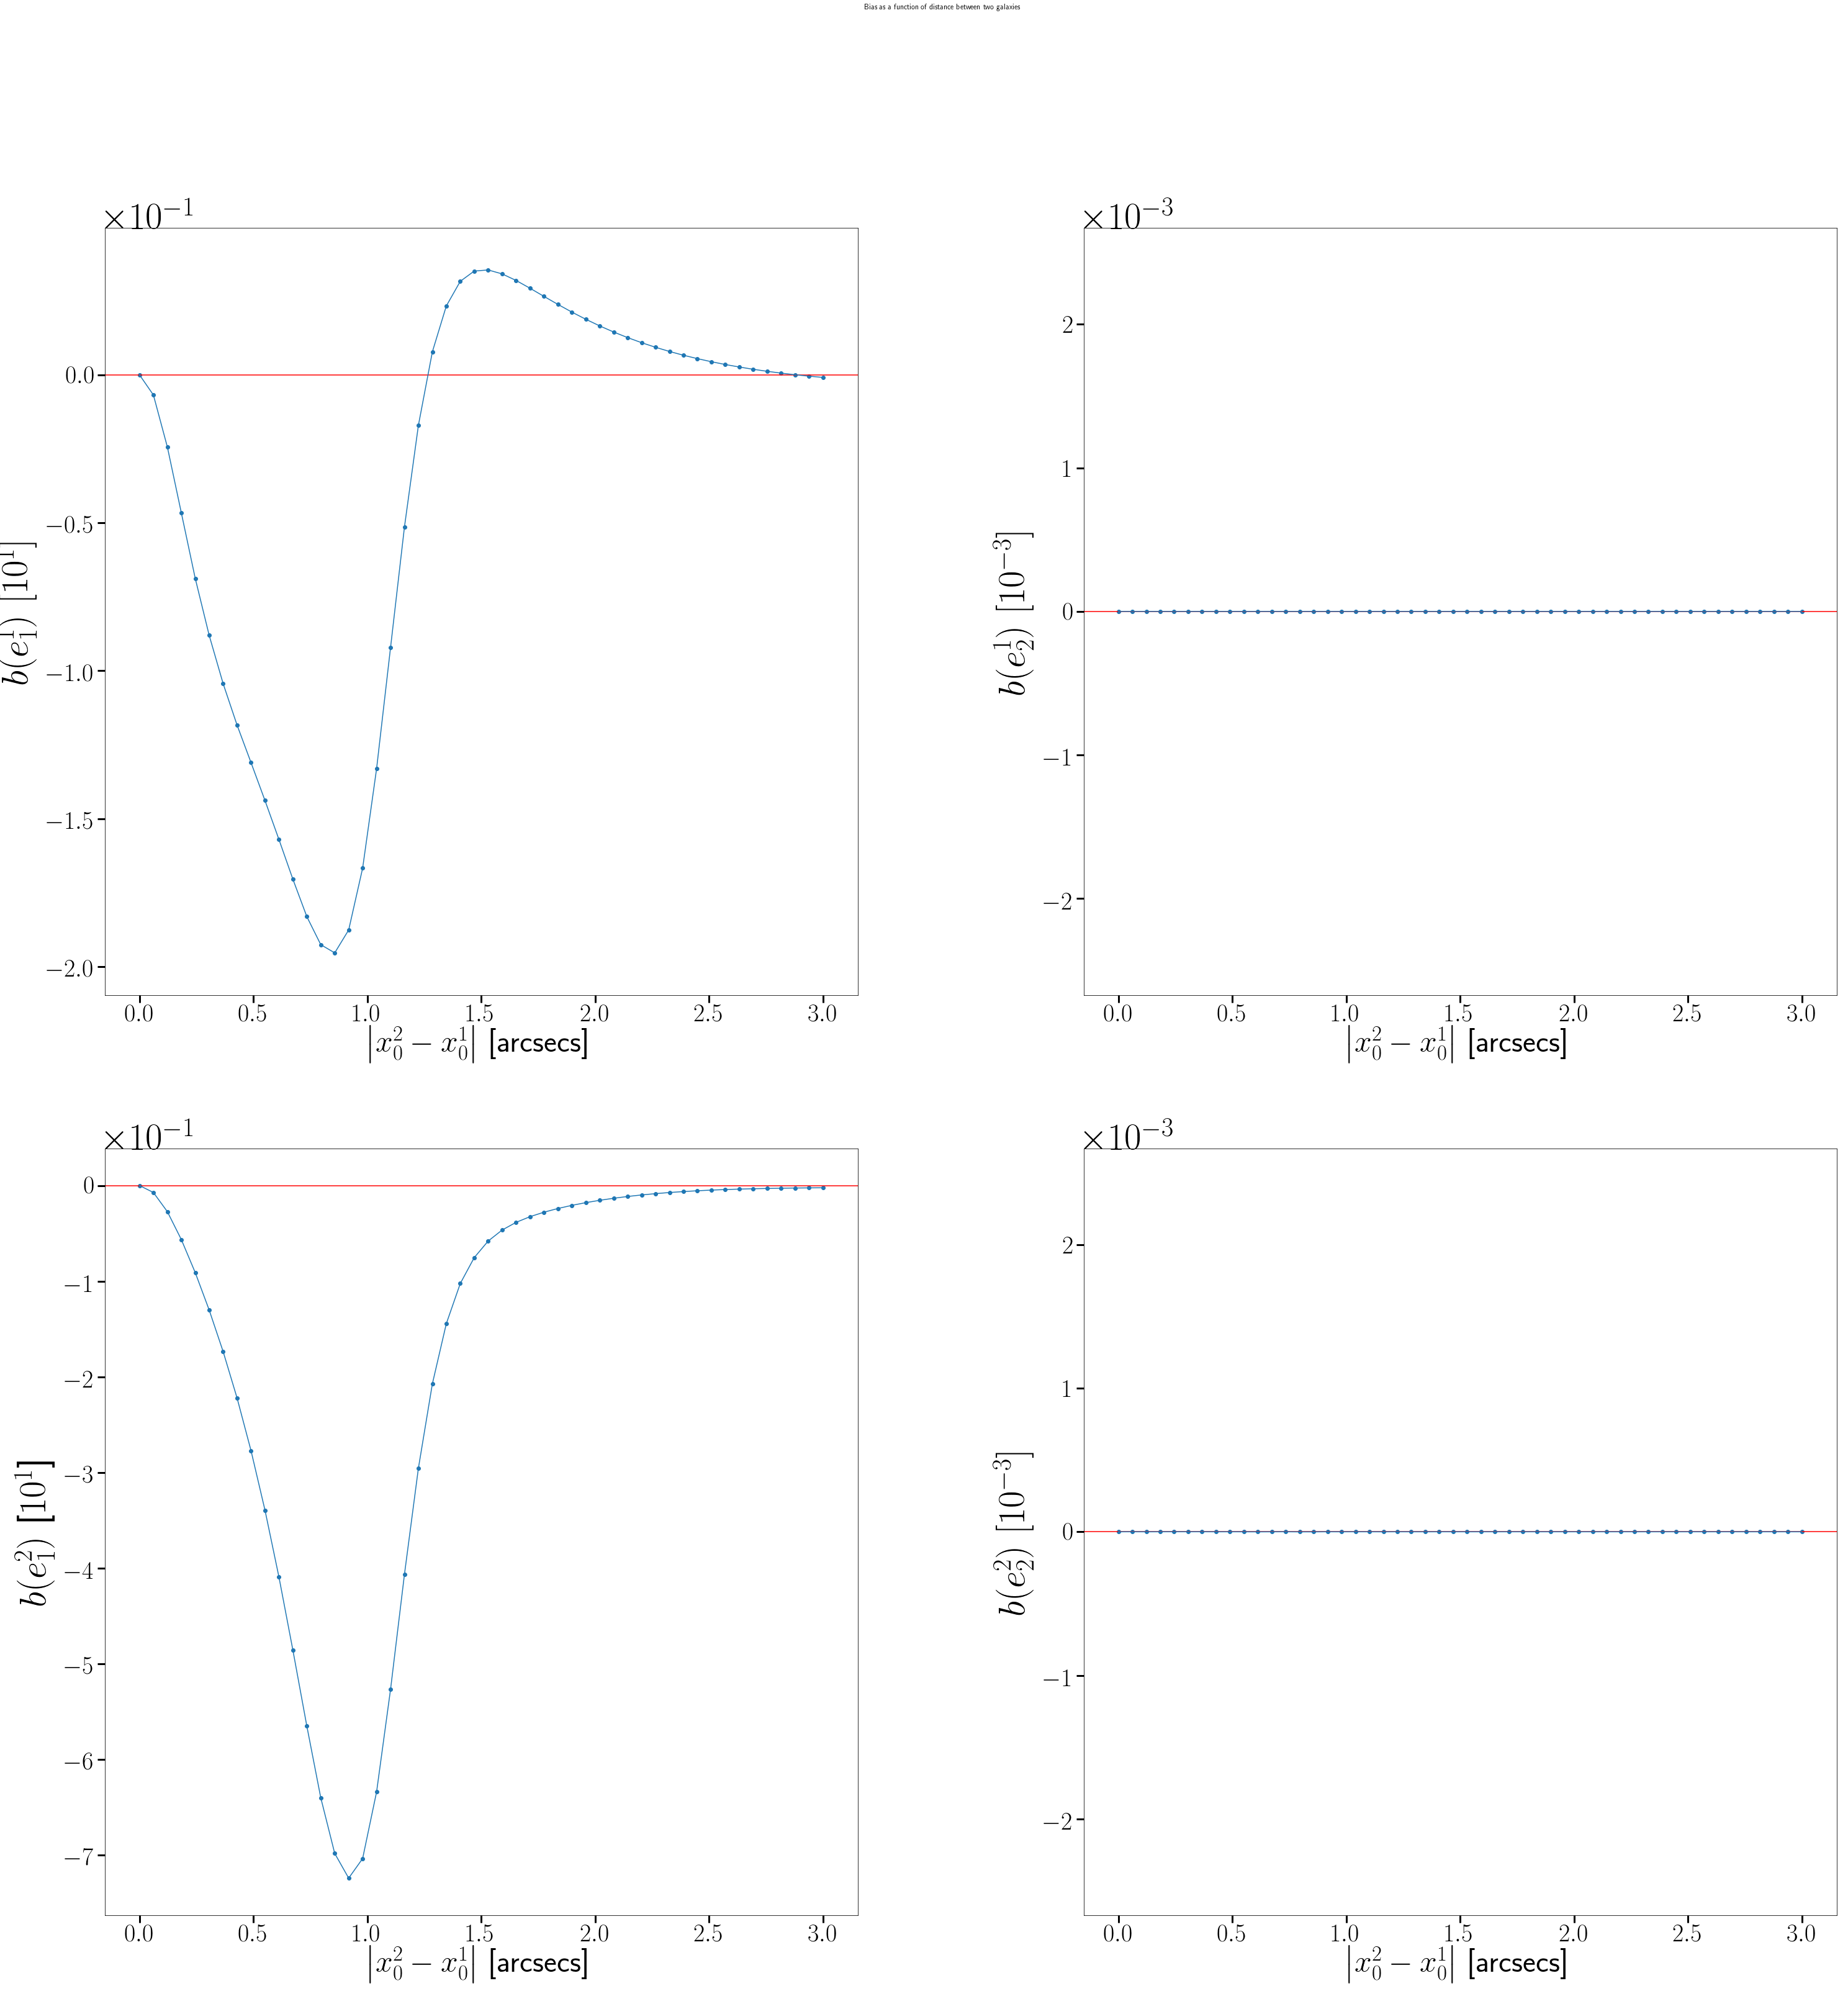

In [41]:
biasSeparation(fish,image_renderer,['e1_1','e2_1','e1_2','e2_2'],4)

### Generate two galaxies with e,beta parametrization 

In [35]:
#parameters of first galaxy to draw. we assume that both galaxies have same psf and snr (which only depends on the background) throughout. 

model_1 = 'gaussian' #possible options of model and psf_model are in documentation. 
e_1 = .2 
beta_1 = 2*np.pi 
hlr_1 = .5
flux_1 = 1. 
x0_1 = 2. #this is in arcsecs
y0_1 = 0. 

#parameters of second galaxy to draw. 
model_2 = 'gaussian'  
e_2 = .2
beta_2 = 0. 
hlr_2 = .3
flux_2 = 1. 
x0_2 = -2.
y0_2 = 0.

#general parameters
snr = 20. 
psf_fwhm = .7
psf_model = 'psf_gaussian'


#project folder name where you want to write galaxy information 
project3 = 'project-tutorial3'

#image parameters 
pixel_scale=.2 
nx = 60
ny = 60 

In [36]:
cmd1 = 'python generate.py -p {0} -gal 1 --galaxy-model {1} --psf_model {2}  --e {3} --beta {4} --x0 {5} --y0 {6} \
--flux {7} --psf_flux 1. --hlr {8} --psf_fwhm {9} --snr {10}'.format(project3,model_1,psf_model,e_1,beta_1,x0_1,y0_1,flux_1,hlr_1,psf_fwhm,snr)
cmd2 = 'python generate.py -p {0} -gal 2 --galaxy-model {1} --psf_model {2}  --e {3} --beta {4} --x0 {5} --y0 {6} \
--flux {7} --psf_flux 1. --hlr {8} --psf_fwhm {9} --snr {10}'.format(project3,model_2,psf_model,e_2,beta_2,x0_2,y0_2,flux_2,hlr_2,psf_fwhm,snr)

In [37]:
p1 = Popen(cmd1, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output1 = p1.stdout.read()
print 'output1:'
print output1
print


output1:




In [38]:
p2 = Popen(cmd2, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output2 = p2.stdout.read()
print 'output2:'
print output2
print 

output2:




In [39]:
import analysis.fisher as fisher
import analysis.galfun as galfun 

In [40]:
g_parameters = galfun.GParameters(project3) #extract parameters from file created by generate.py 
image_renderer = galfun.ImageRenderer(pixel_scale=pixel_scale,
                                      nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, 
                     snr=snr)

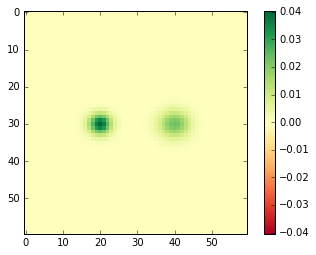

In [41]:
showImage(fish.image.array)
plt.colorbar()

In [34]:
fish.biases

{'beta_1': -5.6297722e-10,
 'beta_2': 7.5788193e-09,
 'e_1': 0.14403602,
 'e_2': 0.22084756,
 'flux_1': 0.01375229,
 'flux_2': 0.0079205809,
 'hlr_1': -0.0093372427,
 'hlr_2': -0.011897152,
 'x0_1': 5.4867655e-07,
 'x0_2': -6.4141909e-07,
 'y0_1': 3.4924597e-10,
 'y0_2': 6.9849193e-10}

In [42]:
fish.biases

{'beta_1': 9.786163e-10,
 'beta_2': -5.994707e-09,
 'e_1': 0.14403541,
 'e_2': 0.22084717,
 'flux_1': 0.013753422,
 'flux_2': 0.0079194857,
 'hlr_1': -0.0093366019,
 'hlr_2': -0.011897225,
 'x0_1': 6.0712307e-07,
 'x0_2': -2.6277223e-07,
 'y0_1': 0.0,
 'y0_2': -9.3132257e-10}

### Bias as a function of the rotation of one of the galaxies. 

In [53]:
def bias_single_angle(fish,image_renderer):
    """Must parametrize at least one galaxy with e/beta. Assume also
    that at least one of the galaxies is non-circular (first galaxy
    given has e1,e2 different from zero - otherwise trivial.). This plots the bias between
    an unchanged galaxy and an elliptical galaxy that is rotating as a
    function of the rotation angle.
    """
    beta_range = (0., 2*np.pi)
    e_range = (.08,.92)
    steps = 5
    figure = plt.figure(figsize=(50, 50))
    figure.suptitle('Bias as a function of e,beta of a galaxy.')
    id_params = deepcopy(fish.g_parameters.id_params)
    snr = fish.snr
    betas = np.linspace(beta_range[0], beta_range[1], steps)
    es = np.linspace(e_range[0], e_range[1], steps)
    xs = []
    ys = [] 
    for beta in betas: 
        for e in es: 
            xs.append(e)
            ys.append(beta)
            
    biases = {}
    for x,y in zip(xs,ys):
        ids = id_params.keys()
        id1 = ids[0]
        id_params[id1]['e'] = x 
        id_params[id1]['beta'] = y
        g_parameters = galfun.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters, image_renderer, snr)
        for i in range(fish.num_params):
            param = fish.param_names[i]
            if param not in biases:
                biases[param] = []
            bias = fish.biases[param]
            biases[param].append(bias)


    for i in range(fish.num_params):
        param = fish.param_names[i]
        ax = figure.add_subplot(2, fish.num_params / 2, i + 1)
        s = ax.scatter(es, betas, c=biases[param])
#         ax.errorbar(angles, biases[param])
        ax.set_title(param, fontsize=14)
        cb = plt.colorbar(s,extend='both')

ValueError: to_rgba: Invalid rgba arg "3.81829e-07"
to_rgb: Invalid rgb arg "3.81829e-07"
cannot convert argument to rgb sequence

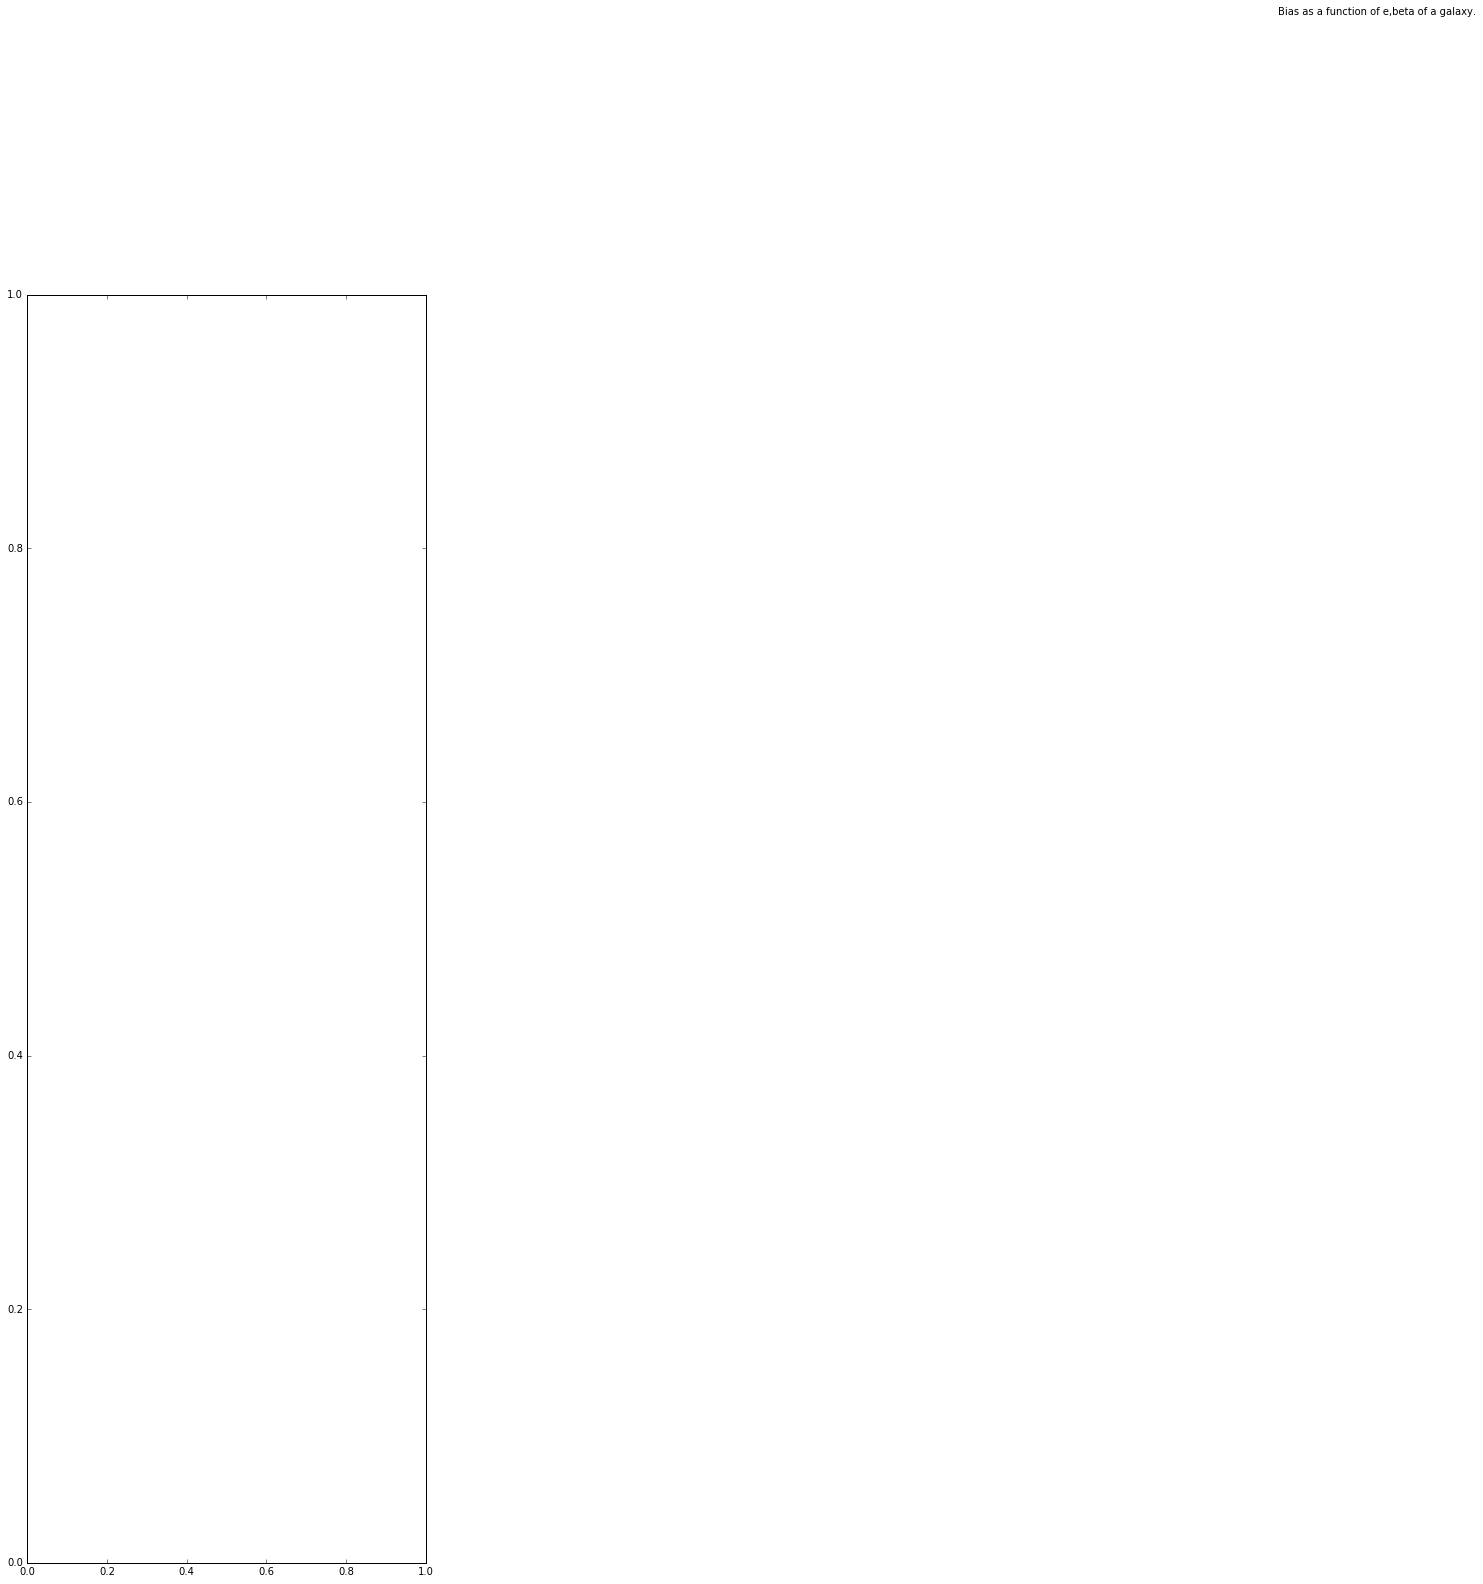

In [54]:
bias_single_angle(fish,image_renderer)

### Bias as a function of both galaxies angle rotating

In [49]:
def biasTwoAngles(fish,image_renderer):
    """Parametrize both galaxies with e,beta. Plot of the bias between two galaxies as their relative orientation changes.
    With a fixed ellipticity e. """
    steps_1 = 3
    steps_2 = 3
    beta_range1 = (0, 2*np.pi)
    beta_range2 = (0, 2*np.pi)
    figure = plt.figure(figsize=(15,15))
    figure.suptitle('Bias as a function two galaxies angular position.',fontsize=18)
    id_params = deepcopy(fish.g_parameters.id_params)
    ids = id_params.keys()
    id1 = ids[0]
    id2 = ids[1]
    snr = fish.snr
    biases = {}
    betas1 = np.linspace(beta_range1[0], beta_range1[1], steps_1)
    betas2 = np.linspace(beta_range2[0], beta_range2[1], steps_2)
    
    xs = [] 
    ys = []
    for beta1 in betas1:
        for beta2 in betas2:
            xs.append(beta1)
            ys.append(beta2)
            id_params[id1]['beta'] = beta1
            id_params[id2]['beta'] = beta2
            g_parameters = galfun.GParameters(id_params=id_params)
            fish = fisher.Fisher(g_parameters, image_renderer,snr)
            for k,param in enumerate(fish.param_names):
                if param not in biases:
                    biases[param] = []
                biases[param].append(fish.biases[param])

    for i,param in enumerate(fish.param_names):
        ax = figure.add_subplot(2, fish.num_params / 2, i + 1,aspect='equal')
        s = ax.scatter(xs, ys, c=biases[param],s=20)
        ax.set_title(param, fontsize=14)
        cb = plt.colorbar(s,extend='both')



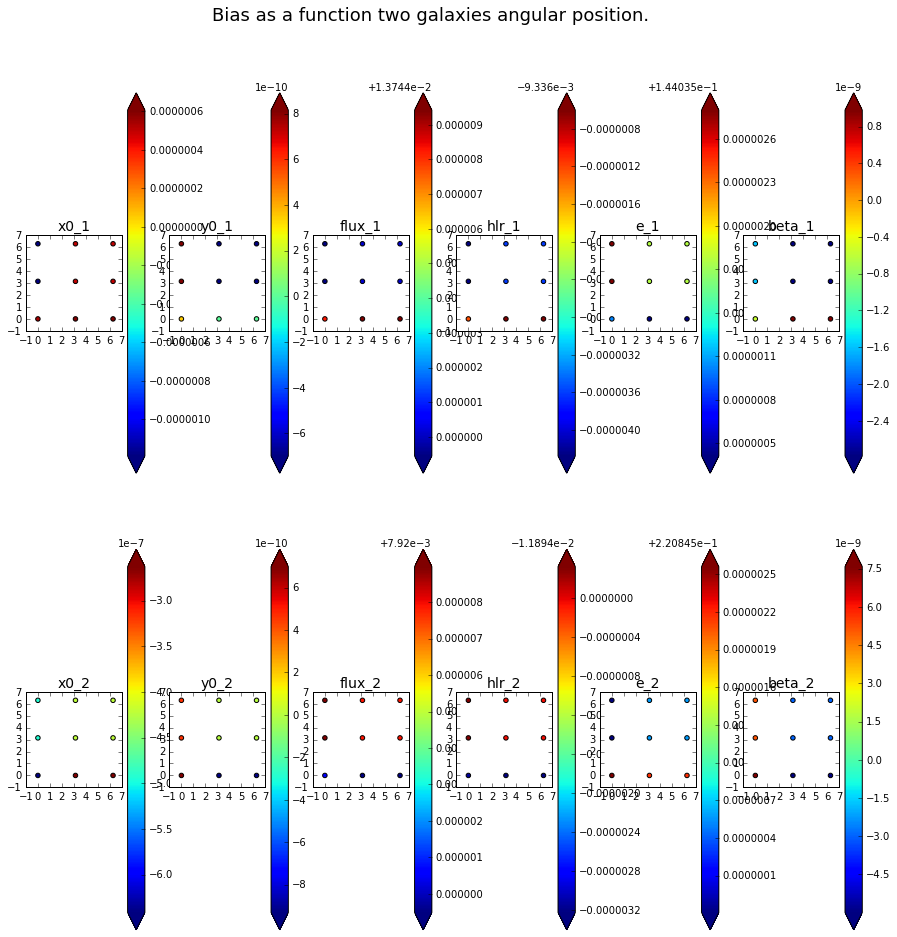

In [50]:
biasTwoAngles(fish,image_renderer)
